In [ ]:
# !pip -q install pydantic
# !pip -q install --upgrade aixplain
# !pip -q install datasets scikit-learn

In [ ]:
# install the libraries: pip install pandas scipy scikit-learn datasets seaborn matplotlib

import os
import json
import re
import ast
from typing import List, Tuple, Optional
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import accuracy_score

In [ ]:
import os
os.environ["TEAM_API_KEY"] = "TEAM_API_KEY"
os.environ["SERPAPI_API_KEY"] = "SERPAPI_API_KEY"

In [16]:
from agentification.utilities.models import AgentExecuteInput, AgentResponse, TeamAgentExecuteInput
from agentification.agent import AgentService
from agentification.utilities.models import Agent, TeamAgent
import aixplain.utils.config as aixplain_config
from agentification.utilities.models import Agent, UtilityTool, UtilityToolType, TeamAgent, ModelTool
from agentification.team_agent import TeamAgentService, TeamAgentExecuteInput

In [ ]:
dataset = load_dataset("fever/feverous", trust_remote_code=True)
df_val = pd.DataFrame(dataset["validation"])

In [ ]:
import ast
import re
import json
from typing import List, Union

def extract_classifications(answer_list: List[Union[str, dict]]) -> List[int]:
    """
    Extract classifications from the answer list.

    Parameters:
        answer_list (List[Union[str, dict]]): List of answers, each being a dictionary, nested dictionary, or string containing the classification.

    Returns:
        List[int]: List of extracted classifications. If an item is invalid or cannot be classified, assigns `4`.
    """
    # Define indicator words
    positive_words = {"claim as true", "supports", "confirms", "is supported", "validates", "verifies", "is true"}
    negative_words = {"refutes", "contradicts", "disagrees", "denies", "disproves", "false", "incorrect", "wrong", "claim is false"}
    not_enough_words = {"insufficient", "not enough", "cannot be verified", "lacks enough information"}

    def handle_dictionary(item: dict) -> int:
        """Extract classification from a dictionary."""
        key_paths = [
            "classification",
            ("Claim Analysis", "Evidence Assessment"),
            ("claim_analysis", "evidence_classification"),
            ("query", "classification"),
        ]
        for path in key_paths:
            if isinstance(path, str):
                classification = item.get(path)
            elif isinstance(path, tuple):
                classification = item
                for key in path:
                    classification = classification.get(key) if isinstance(classification, dict) else None
            if classification is not None:
                return int(classification)
        return 4

    def handle_string(item: str) -> int:
        """Extract classification from a string."""
        item_lower = item.lower()
        match = re.search(r'\b(\d)(?=[:.])', item_lower)
        if match:
            return int(match.group(1))
        elif any(word in item_lower for word in positive_words):
            return 0
        elif any(word in item_lower for word in negative_words):
            return 1
        elif any(word in item_lower for word in not_enough_words):
            return 2
        elif "not solvable" in item_lower:
            return 4
        return 4

    classifications = []
    for item in answer_list:
        try:
            # Handle direct digit strings
            if isinstance(item, str) and item.strip().isdigit():
                classifications.append(int(item))
                continue

            # Handle JSON-like strings enclosed in backticks
            if isinstance(item, str):
                json_content = re.findall(r'```json(.*?)```', item, re.DOTALL)
                if json_content:
                    try:
                        item = ast.literal_eval(json_content[0].strip())
                    except (ValueError, SyntaxError):
                        pass  # If parsing fails, leave as string

            # Handle dictionary input
            if isinstance(item, dict):
                classifications.append(handle_dictionary(item))
                continue

            # Handle plain strings
            if isinstance(item, str):
                classifications.append(handle_string(item))
                continue

            # Default for invalid or unparsable items
            classifications.append(4)
        except Exception:
            classifications.append(4)

    return classifications


In [20]:
def calculate_accuracy(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy

In [21]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_metrics(true_labels, predicted_labels):
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    # Calculate F1-score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    
    # Get detailed classification report
    report = classification_report(true_labels, predicted_labels, zero_division=1)
    
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Create confusion matrix visualization
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"F1-Score: {f1:.4f}")
    print("\nDetailed Classification Report:")
    print(report)
    
    return accuracy, f1

In [22]:
def save_predictions(data_val, file_name="predict_val.csv", column="New Column"):
    """
    Save or update predictions in a CSV file, adding a new column each time.

    Parameters:
        data_val (list): The data to be saved as a new column.
        file_name (str): The name of the CSV file.
        column (str): The name of the column to add.
    """
    if os.path.exists(file_name):
        # Load the existing file
        df_output = pd.read_csv(file_name)
        if len(df_output) != len(data_val):
            raise ValueError(f"Length of new column ({len(data_val)}) does not match existing rows ({len(df_output)}).")
            
        # Add the new column
        df_output[column] = data_val
        print(f"Added column '{column}' to existing file '{file_name}'.")
    else:
        # Create a new DataFrame with the data
        df_output = pd.DataFrame(data_val, columns=[column])
        print(f"File '{file_name}' created with column '{column}'.")

    # Save the updated DataFrame back to the CSV file
    df_output.to_csv(file_name, index=False)

In [ ]:
ROLE = """You are an AI fact verification agent trained to research, analyze claims, and classify them into specified categories.

You have access to search tools to explore the web and verify claims. If ethical concerns arise with the input, classify the task as **NOT_SOLVABLE** and provide a clear explanation of the issue.

Always adhere strictly to the provided output format.

Output format:
```json
{{
  "classification": "Answer",
  "evidence": "A concise explanation of how the evidence supports the classification."
}}
```"""

In [77]:
PROMPT="""Analyze and classify the claim below using the outlined architecture:

    0: The evidence explicitly supports the claim as true.
    1: The evidence explicitly refutes or contradicts the claim.
    2: The evidence is insufficient, ambiguous, or lacks enough information to verify the claim.

Claim: {query}

Provide your response strictly in the required ***JSON format***:"""

In [79]:
from time import gmtime, strftime
curr = time.time()
c_time = strftime("%d%b%Y_%H:%M:%S", gmtime(curr))
print(c_time)

02Jan2025_17:33:26


In [248]:
agent = Agent(
                id="",
                name="Search and Fact Verification Assistant",
                assets=[
                        UtilityTool(
                            type="utility",
                            utility=UtilityToolType.SERPAPI,
                            description="A search engine. Useful for when you need to answer questions about current events. Input should be a search query.",
                        ),
                ],
                description=ROLE,
                status="onboarded",
                teamId=1,
                llmId="66b2708c6eb5635d1c71f611", #llama 3.1B
            )

In [ ]:
n=20
answer_val = []
for idx, row in enumerate(df_val["claim"][:n]):
    for i in range(3):
        query = row.replace("–", "-")
        inp = PROMPT.format(query=query) 
        response = AgentService.run(
                        AgentExecuteInput(
                            agent=agent,
                            query=str(inp),
                            chat_history=[],
                            api_key=os.getenv("TEAM_API_KEY"),
                            session_id="1234",
                            executionParams={"maxIterations": 20},
                        ),
                        chat_history=[],
                )
        answer_val.append(response.output)
        print("============= New Problem (Single Agent) ===============")
        print(inp)
        print(response.output)
        print()
        print("============= Next Problem (Single Agent) ===============")
        with open(f"docs/experiments/fever/models/single_agent_llama/results/{idx}_{i}:{c_time}.json", "w") as f:
            f.write(response.model_dump_json(indent=4))
            
        if response.output.lower().startswith("sorry") is False:
            break

In [250]:
print(len(answer_val))
answer_val

20


['{"classification": "2", "evidence": "The information obtained does not explicitly support or refute the claim about Algebraic logic having five Logical systems and Lindenbaum-Tarski algebra, which includes Physics algebra and Nodal algebra. The evidence is insufficient, ambiguous, or lacks enough information to verify the claim."}',
 'The evidence explicitly supports the claim as true. According to the information obtained, Aramais Yepiskoposyan played for FC Ararat Yerevan from 1986 to 1991, which verifies the claim.',
 "The claim that Scot's book is titled The Discoverie of Witchcraft is true, however information about the printer giving his name at the end and the four dedications, one of which is to Sir Roger Manwood, is not found in the available information, thus the evidence is insufficient to fully verify the claim.",
 '{"classification": "0", "evidence": "The information obtained from the search queries confirms that Family Guy is an American animated sitcom with the mention

In [256]:
n = 20
res = extract_classifications(answer_val)
res

[2, 0, 0, 0, 0, 2, 1, 2, 0, 2, 0, 0, 2, 1, 0, 1, 1, 1, 0, 1]

In [264]:
print(list(df_val[:n]["label"]))

[1, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1]


In [258]:
true_labels = df_val[:n]["label"].tolist()
predicted_labels = res
calculate_accuracy(true_labels, predicted_labels)

Accuracy: 50.00%


0.5

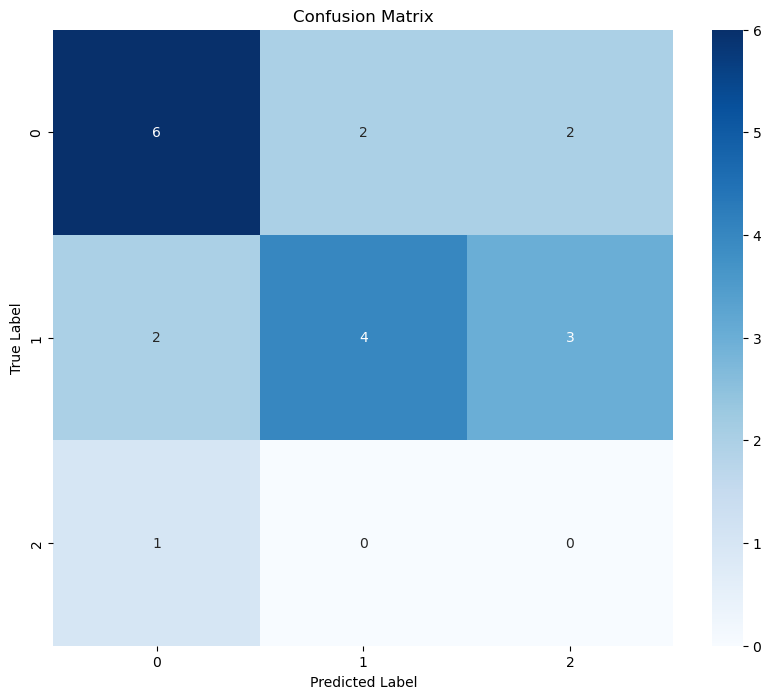

Accuracy: 50.00%
F1-Score: 0.5558

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.67      0.44      0.53         9
           2       0.00      0.00      0.00         1

    accuracy                           0.50        20
   macro avg       0.44      0.35      0.39        20
weighted avg       0.63      0.50      0.56        20



(0.5, 0.5557894736842105)

In [259]:
calculate_metrics(true_labels, predicted_labels)

In [255]:
save_predictions(answer_val, f"prediction_single.csv:{c_time}", "pred")

File 'prediction_single.csv:02Jan2025_17:33:26' created with column 'pred'.


In [ ]:
# Multi Agent

In [ ]:
extract_agent = Agent(
                        id="",
                        name="Fact Extraction Agent",
                        assets=[
                            UtilityTool(
                                type="utility",
                                utility=UtilityToolType.SERPAPI,
                                description="A search engine. Useful for when you need to answer questions about current events. Input should be a search query.",
                            ),
                        ],
                        description="You are an AI tasked with the extraction of relevant fact based on the user query from the internet using google search engines.",
                        status="onboarded",
                        teamId=1,
                        llmId="66b2708c6eb5635d1c71f611", #llama 3.1B
                    )
# This agent can be optional. The multi-agent still works fine without it.
fact_agent = Agent(
                    id="",
                    name="Fact Verification and Label Assignment Agent",
                    assets=[],
                    description="You are an AI responsible for verifying facts extracted from searches and assigning labels to them based on their alignment with the user's query, then outputting the labeled results.",
                    status="onboarded",
                    teamId=1,
                    llmId="66b2708c6eb5635d1c71f611",  
                )

community = TeamAgent(
                        id="66e81e65384523f1ba02ca6c",
                        agents=[extract_agent, fact_agent],
                        links=[],
                        name="Search and Fact Verification Assistant",
                        status="onboarded",
                        teamId=1,
                        llmId="66b2708c6eb5635d1c71f611", #Llama 3.1 70B
                        supervisorId="66b2708c6eb5635d1c71f611", #Llama 3.1 70B
                        plannerId="66b2708c6eb5635d1c71f611", #Llama 3.1 70B
                        assets=[],
                        description=ROLE
                    )

In [ ]:
answer_valm = []
n=20
for idx, row in enumerate(df_val["claim"][:n]):
    for i in range(3):
        query = row.replace("–", "-")
        inp = PROMPT.format(query=query) 
        response = TeamAgentService.run(
            TeamAgentExecuteInput(
                agent=community,
                query=inp,
                chat_history=None,
                api_key=os.getenv("TEAM_API_KEY"),
                session_id="1234",
                executionParams={"maxIterations": 60},
                verbose=True,
            )
        )
        answer_valm.append(response.output)
        print("============= New Problem (Multi Agent) ===============")
        print(inp)
        print(response.output)
        print()
        print("============= Next Problem (Multi Agent) ===============")
        with open(f"docs/experiments/fever/models/multi_agent_llama/results/{idx}_{i}:{c_time}.json", "w") as f:
            f.write(response.model_dump_json(indent=4))
            
        if response.output.lower().startswith("sorry") is False:
            break

In [82]:
print(len(answer_valm))
answer_valm

20


['```json\n{\n  "Claim Analysis": {\n    "Claim": "Algebraic logic has five Logical systems and Lindenbaum-Tarski algebra which includes Physics algebra and Nodal algebra (provide models of propositional modal logics)",\n    "Evidence Assessment": 0,\n    "Justification": "The evidence explicitly supports the claim as true. Algebraic logic indeed encompasses various logical systems and is closely related to Lindenbaum-Tarski algebra, which provides a framework for studying logical structures through algebraic means. This includes the incorporation of Physics algebra and Nodal algebra, contributing to the modeling of propositional modal logics."\n  },\n  "Worker": {\n    "Name": "Fact Extraction Agent",\n    "Input": "Extract relevant information from the internet about Algebraic logic, Logical systems, Lindenbaum-Tarski algebra, Physics algebra, and Nodal algebra, specifically focusing on the claim that Algebraic logic has five Logical systems and Lindenbaum-Tarski algebra, which inclu

In [241]:
res = extract_classifications(answer_valm)
res

[0, 0, 4, 4, 0, 2, 1, 1, 2, 0, 2, 0, 2, 1, 1, 1, 2, 1, 0, 1]

In [263]:
print(list(df_val[:n]["label"]))

[1, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1]


In [244]:
true_labels = df_val[:n]["label"].tolist()
predicted_labels = res
calculate_accuracy(true_labels, predicted_labels)

Accuracy: 50.00%


0.5

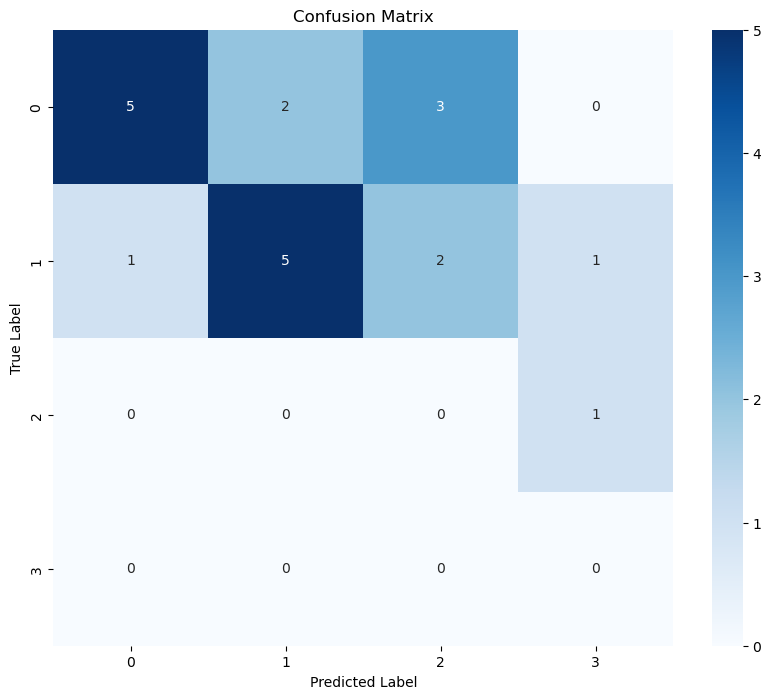

Accuracy: 50.00%
F1-Score: 0.5938

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.71      0.56      0.62         9
           2       0.00      0.00      0.00         1
           4       0.00      1.00      0.00         0

    accuracy                           0.50        20
   macro avg       0.39      0.51      0.31        20
weighted avg       0.74      0.50      0.59        20



(0.5, 0.59375)

In [245]:
true_labels = df_val[:n]["label"].tolist()
predicted_labels = res
calculate_metrics(true_labels, predicted_labels)

In [246]:
save_predictions(answer_valm, f"prediction_multi:{c_time}.csv", "pred")

Added column 'pred' to existing file 'prediction_multi:02Jan2025_17:33:26.csv'.


In [97]:
prevOut = pd.read_csv("prediction_multi:02Jan2025_17:33:26.csv")
prev = prevOut["pred"]